# Bagging Classifier for HC-Sleep Data
#### Takes pre-computed feature matrix and trains and tests a bagging classifier to classify sleep staging

## Initializations

In [6]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from random import randint
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm
import matplotlib 
import matplotlib.pyplot as plt
import datetime
import math
import statistics

import seaborn as sns
import imblearn as imb 
from imblearn.ensemble import BalancedRandomForestClassifier, BalanceCascade, BalancedBaggingClassifier
from sklearn.metrics import f1_score as F1

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from scipy.interpolate import interp1d, interp2d
from IPython.display import clear_output

from random import shuffle

In [7]:
mods = ['ACCL','ECG','LDH']

features = {'ACCL':['Mean_X_L', 'Mean_Y_L', 'Mean_Z_L', 'Range_X_L', 'Range_Y_L',
                    'Range_Z_L', 'IQR_X_L', 'IQR_Y_L', 'IQR_Z_L', 'STD_X_L', 'STD_Y_L',
                    'STD_Z_L', 'Skew_X_L', 'Skew_Y_L', 'Skew_Z_L', 'Kurtosis_X_L',
                    'Kurtosis_Y_L', 'Kurtosis_Z_L', 'RMS_X_L', 'RMS_Y_L', 'RMS_Z_L',
                    'Variance_X_L', 'Variance_Y_L', 'Variance_Z_L', 'Min_X_L', 'Min_Y_L',
                    'Min_Z_L', 'Max_X_L', 'Max_Y_L', 'Max_Z_L', 'Pearson_Coeff_X-Y_L',
                    'Pearson_Pval_X-Y_L', 'Pearson_Coeff_Y-Z_L', 'Pearson_Pval_Y-Z_L',
                    'Pearson_Coeff_Z-X_L', 'Pearson_Pval_Z-X_L'],
            'ECG':['rmssd','nni_50','pnni_50','nni_20',
                   'pnni_20','mean_hr','max_hr','min_hr','std_hr',
                   'total_power','vlf','lf','hf','lf_hf_ratio'],
            'LDH':['Mean_LDH', 'Max_LDH', 'Min_LDH', 'Range_LDH']
           }

resolution = {'Min':{0:1,1:1},
              'Med':{0:1,2:1,5:1},
              'Max':{0:1,1:1,3:1,5:1}}
shapes = {'Min':np.array([0, 1]),
          'Med':np.array([0, 2, 5]),
          'Max':np.array([0, 1, 3, 5])}
sizes =  {'Min':{0:0,1:1},
          'Med':{0:0,2:1,5:2},
          'Max':{0:0,1:1,3:3,5:5}}
classBreakdown = {'Min':2,
                  'Med':3,
                  'Max':4}
labels = {'Min':['Wake','Sleep'],
          'Med':['Wake','NREM','REM'],
          'Max':['Wake','Light','Deep','REM']}

def plot_confusion_matrix(df_confusion, res, path=False, cmap=plt.cm.Greens):
    labels = {'Min':['Wake','Sleep'],
              'Med':['Wake','NREM','REM'],
              'Max':['Wake','Light','Deep','REM']
             }
    fig, ax = plt.subplots()
    cax = ax.matshow(df_confusion, cmap=cmap,vmin=0, vmax=1)
    plt.colorbar(cax)
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, labels[res], rotation=45)
    plt.yticks(tick_marks, labels[res])
    plt.ylabel(df_confusion.index.name, fontsize=12)
    plt.title('Actual Sleep Stage',y=1.18, fontsize=12)
    plt.tight_layout()
    
    for (i, j), z in np.ndenumerate(df_confusion):
        ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
               bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.2'))
    if path:
        plt.savefig(path)
        plt.show()
        plt.close('all')
    else:
        plt.show()
        
def plot_rocs(y_test,y_prob):
    y_roc = pd.get_dummies(y_test)
    num_plots = len(np.unique(y_test))
    
    interpLen = 300
    x = np.linspace(0,1,interpLen)
    f = {}
    
    fpr = {}
    tpr = {}
    thrs = {}
    auc = {}
    
    rocdf = pd.DataFrame()
    fpr = np.linspace(0,1,100)
    tprs = []
    for x, cnt in zip(np.unique(y_test),[y for y in range(len(np.unique(y_test)))]):
        mask = y_prob[...,cnt]
        probability_not_x = np.sort(mask[y_test!=x,...],axis=0)
        count_not_stage_x = sum(y_test!=x)
        tpr=[]
        for f in fpr:
            index_of_fpr = count_not_stage_x-int(count_not_stage_x*f)-1
            threshold = probability_not_x[index_of_fpr]

            if f==1:
                threshold=0
            tpr_t = sum(y_prob[y_test==x,cnt]>threshold)/sum(y_test==x)
            tpr.append(tpr_t)
        tprs.append(tpr)

    return tprs

## Classifier

C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


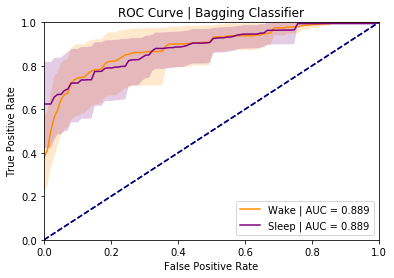

Accuracy: 0.8336933045356372
Average AUC: 0.889438395770696


C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


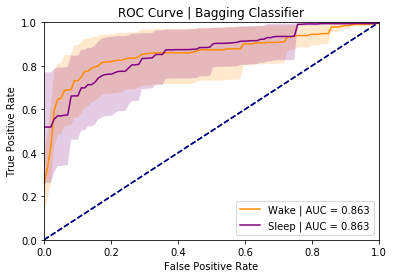

Accuracy: 0.857451403887689
Average AUC: 0.8632479240036812


C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


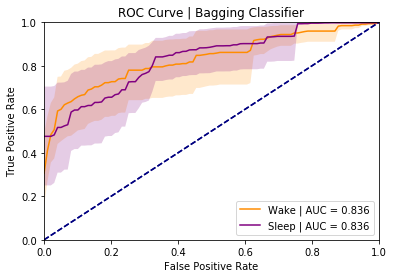

Accuracy: 0.8628509719222462
Average AUC: 0.8360102938427871


C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


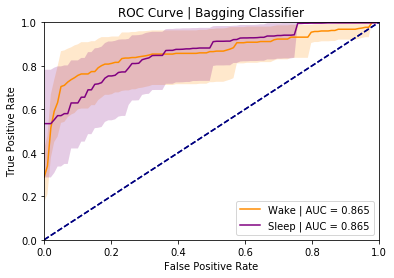

Accuracy: 0.8677105831533477
Average AUC: 0.8650402954409439


C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


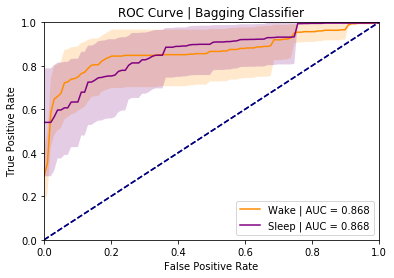

Accuracy: 0.8709503239740821
Average AUC: 0.8684465410320201


C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


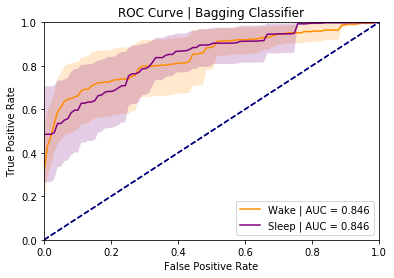

Accuracy: 0.8671706263498921
Average AUC: 0.8460843146201111


C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


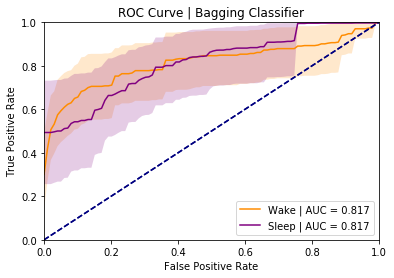

Accuracy: 0.8428725701943844
Average AUC: 0.8171954483413636


C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


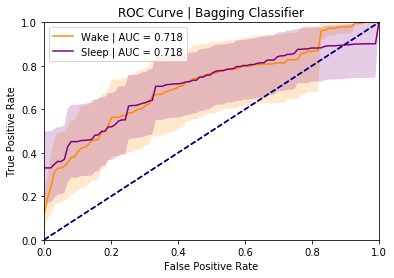

Accuracy: 0.7580993520518359
Average AUC: 0.7184406431374647


C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alexj\Anaconda3\envs\Tf-v4\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


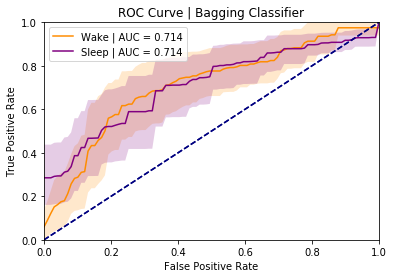

Accuracy: 0.7370410367170627
Average AUC: 0.714340319386279


In [16]:
Outputs = {'Accuracy':{},
           'Ensemble':{},
           'Confusion':{},
           'Data':{},
           'ROC':{}}
# Subject excluded due to sensor malfunction
dont_use = ['HCS002']

# Path to Saved features from 'Feature_Extraction.ipynb'
path = ''
subjects = [x for x in sorted(os.listdir(path)) if x not in dont_use]

# Initialize outputs
aucs_per_itr = {}
aucs_per_itr['Avg'] = []
aucs_per_itr['Std'] = []
itr_num = 0
all_cons = {}
tot_actual = {}
tot_pred = {}

# Get feature list for minimal sensor set
ftlst = ['Stage']
for mod in mods:
    ftlst.extend(features[mod])

# Iterate through 2-, 3-, and 4-stage resolutions
for res in ['Min','Med','Max']:
    tot_actual[res] = []
    tot_pred[res] = []
    aucScore = []
    total_runs=0

#     Initialize confusion matrix
    confusion_total = pd.crosstab(shapes[res],
                                  shapes[res],
                                  colnames=['Actual Stage'],
                                  rownames=['Predicted Stage'])
    for x in shapes[res]:
        for y in shapes[res]:
            confusion_total[x][y] = 0.0
            confusion_max[x][y] = 0.0
#     Initialize ROC Curve
    rocs = np.empty((11,300,int(2*len(shapes[res]))))
    fpr_all = np.linspace(0,1,100); tpr_all = {}; auc_all = {}; recall_all = {}
    for classNum in range(len(shapes[res])):
        tpr_all[classNum] = []
        auc_all[classNum] = []
        recall_all[classNum] = []

#     Iterate through all subjects - Leave-One-Out Cross Validation
    for leave_out in subjects:
        print(leave_out,end='\r')
        dataset_name = str(itr)+'_'+str(res)+'_'+str(leave_out)

        fts  = pd.DataFrame(columns=ftlst)
        flag = 0
        
#         Compile feature matrix for training and testing sets
        for sub in subjects:
            path_new = os.path.join(path,sub,'Features'+res+'.pickle')

            if sub == leave_out:
                fts_test = pickle.load(open(path_new,'rb'))
                features_test = fts_test.loc[:,ftlst]
            elif flag == 0:
                fts_train = pickle.load(open(path_new,'rb'))
                features_train = fts_train.loc[:,ftlst]
                flag = 1
            else:
                df_new = pickle.load(open(path_new,'rb'))
                features_train = features_train.append(df_new.loc[:,ftlst],ignore_index=True,sort=False)


        y_train = features_train.loc[:,'Stage'].values.astype('int')
        features_train.drop('Stage',inplace=True,axis=1)
        x_train = features_train

        y_test = features_test.loc[:,'Stage'].values.astype('int')
        features_test.drop('Stage',inplace=True,axis=1)
        x_test = features_test
        del features_test, features_train

        
#         Initialize model for specific resolution
        if res in ['Min']:
            clf = BalancedBaggingClassifier(
                n_estimators=130,
                n_jobs=-1,
                replacement=True,
                random_state=10
                sampling_strategy='auto'
            )
        elif res in ['Med']:
            clf = BalancedRandomForestClassifier(
                n_estimators=130,
                random_state=61,
                n_jobs=-1,
                min_samples_split=3,
                min_samples_leaf=2,
                verbose=0,
                criterion='gini',
                max_features=None,
                warm_start=False,
                max_depth=None,
            )
        elif res in ['Max']:
            clf = BalancedBaggingClassifier(
                n_estimators=130,
                n_jobs=-1,
                replacement=True,
                random_state=7
                sampling_strategy='auto'
            )
        
#         Fit model to training data
        clf.fit(x_train.values,y_train)

#         Predict using testing set
        y_pred = clf.predict(x_test.values)
        y_prob = clf.predict_proba(x_test.values)
        y_roc = pd.get_dummies(y_test)

        loopItr = 0
        
#         Get ROC values
        for rocNum in plot_rocs(y_test,y_prob):
            tpr_all[loopItr].append(rocNum)
            auc_all[loopItr].append(sklearn.metrics.roc_auc_score(y_roc.iloc[:,loopItr].values,y_prob[:,loopItr]))
            loopItr+=1

#         Get confusion matrix
        confusion = pd.crosstab(y_pred,y_test,colnames=['Actual Stage'],
                                rownames=['Predicted Stage'])
        confusion_norm = confusion/1.0
        confusion_total = confusion_total/1.0
        cols = confusion_norm.columns.tolist()
        rws = confusion_norm.index.tolist()
        sums = [float(i) for i in confusion_norm.sum().tolist()]
        runs = 0
        
#         Get accuracy percentages from classification output
        for jj in cols:
            for ii in rws:
                confusion_norm[jj][ii] = float(confusion_norm[jj][ii]/sums[runs])
                confusion_total[jj][ii] += confusion_norm[jj][ii]
            try:recall_all[runs].append(confusion_norm[jj][jj])
            except:recall_all[runs].append(0)
            runs += 1

        total_runs+=1

#     Plot ROC Curve
    auc_avgs = []
    color_list = ['darkorange','purple','green','royalblue']
    if res in ['Max']:
        color_list = ['darkorange','purple','royalblue','green']

    for classNum in range(len(shapes[res])):
        tpr_all[classNum] = np.asarray(tpr_all[classNum])
        auc_avgs.append(np.mean(auc_all[classNum]))
        sns.tsplot(data=tpr_all[classNum],
                   time=fpr_all,
                   ci=95,
                   color=color_list[classNum],
                   condition='{:^s} | AUC = {:^0.3f}'.format(str(labels[res][classNum]),
                                                             np.mean(auc_all[classNum])))
        plt.plot([0,1],[0,1],color='navy',linestyle='--')
        plt.ylim(0,1)
    plt.title('ROC Curve | Bagging Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

#     Average confusion matrix for resolution run
    confusion_total = confusion_total/total_runs
    
    plot_confusion_matrix(confusion_total,res)
    
    all_cons['total'] = confusion_total
    cols = confusion_max.columns.tolist()
    runs = 0
    tp_tn = 0
    for jj in cols:
        tp_tn+=confusion_max[jj][jj]
    tp_tn_fp_fn = confusion_max.sum().sum()

    print('Accuracy: '+str(tp_tn/tp_tn_fp_fn))
    print('Average AUC: '+str(np.mean(auc_avgs)))

    itr_num+=1